In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
from pylab import rcParams

## Loading the Data

In [5]:
# df = pd.read_csv('Data/cleaned_amd_data.csv',parse_dates=["date","exdate"])
# df_test = pd.read_csv('Data/cleaned_amd_data.csv',parse_dates=["date","exdate"])

df = pd.read_csv('Data/4.AMD_option_stock_data_cleaned.csv',parse_dates=["date","exdate"])
df_test = pd.read_csv('Data/4.AMD_option_stock_data_cleaned.csv',parse_dates=["date","exdate"])

data = df                                    # will be used after ARIMA model

pd.set_option('display.max_columns',None)
df = df.set_index('date')
df_test = df_test.set_index('date')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 735098 entries, 2021-01-04 to 2023-02-28
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   symbol           735098 non-null  object        
 1   exdate           735098 non-null  datetime64[ns]
 2   cp_flag          735098 non-null  object        
 3   strike_price     735098 non-null  int64         
 4   best_bid         735098 non-null  float64       
 5   best_offer       735098 non-null  float64       
 6   volume           735098 non-null  int64         
 7   open_interest    735098 non-null  int64         
 8   impl_volatility  735098 non-null  float64       
 9   delta            735098 non-null  float64       
 10  gamma            735098 non-null  float64       
 11  vega             735098 non-null  float64       
 12  theta            735098 non-null  float64       
 13  optionid         735098 non-null  int64         
 14  cont

### Simple moving average 

Let us start with a very simple moving average model. To simplify further, we replace all the options that share the same date with a single entry comprised of the mean value. 

<Axes: xlabel='date'>

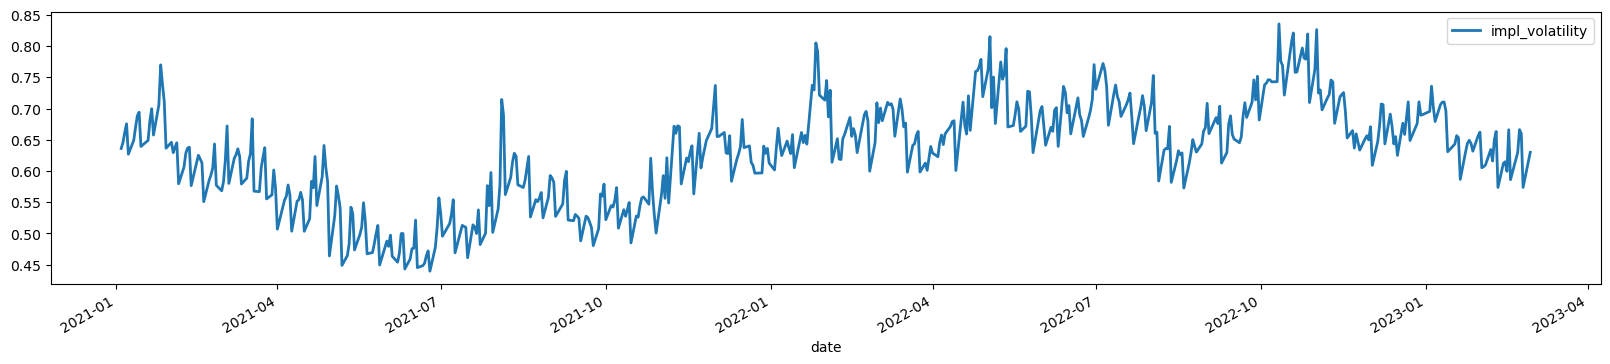

In [6]:
df = df[['impl_volatility']] # Only keep voatility and price

df.reset_index() # To make date into a column
df = df.groupby('date').mean() # To replace all these that share date by their mean
df[['impl_volatility']].plot(lw=2, figsize=(20,4)) # plot volatility

Text(0.5, 1.0, 'Rolling average')

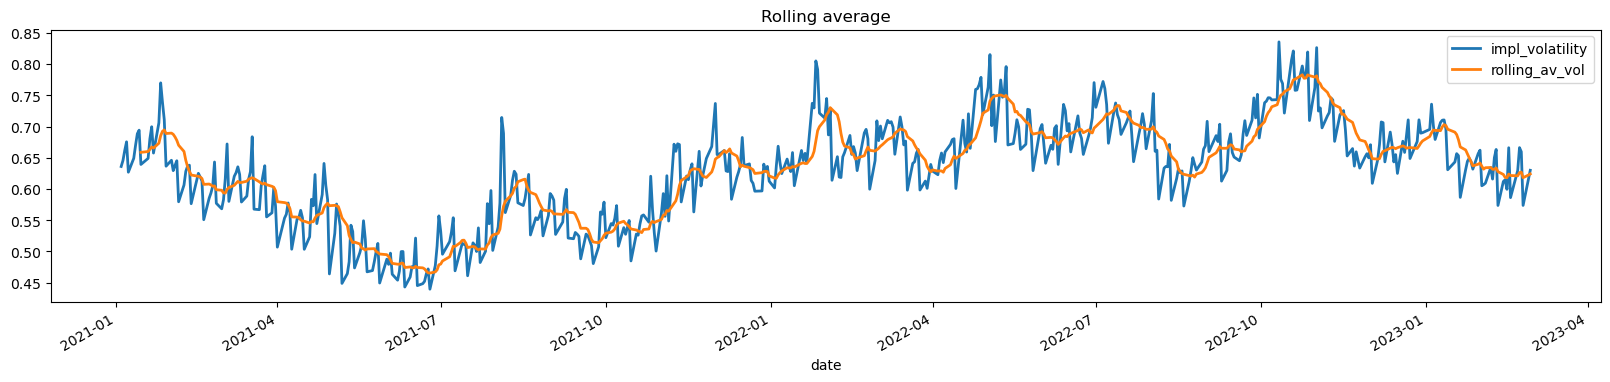

In [7]:
# For call option volatility
df['rolling_av_vol'] = df['impl_volatility'].rolling(10).mean()
df[['impl_volatility','rolling_av_vol']].plot(lw=2, figsize=(20,4))
plt.legend(loc='best')
plt.title('Rolling average')

### Baseline model: ARIMA

An ARIMA (AutoRegressive Integrated Moving Average) model is a widely used time series forecasting method. It is composed of three main components: 

1. **AutoRegressive (AR) term:** This part models the relationship between an observation and a number of lagged observations (i.e., its own past values). It implies the current value of a series is dependent on its previous values. 

2. **Integrated (I) term:** This component involves differencing the time series data to make it stationary. Stationarity means that the statistical properties of the series (like mean and variance) remain constant over time. 

3. **Moving Average (MA) term:** This part models the dependency between an observation and a residual error from a moving average model applied to lagged observations. 

We choose this as our baseline model as it is easy to implement and understand, and is independent of the other variables of the option making it a good benchmark against more complex models. 

**Predicting with the ARIMA model**

ARIMA is not useful for long term predictions as it very quickly converges to a constant. We decide to proceed naively, split our data to train and test and try to make a prediction. In the mean time, we figure out what are good enough variables to use in our ARIMA models. 

We use ARIMA from statsmodels. This is a composite of an autoregressive model, $AR(𝑝)$, an integration model, $I(𝑑)$, and a moving average model, $MA(𝑞)$, which is passed via the tuple `order(p,d,q)`. Here we shall use again a window of `𝑞=10`, `p=0`, and `d=0`:

p-value: 0.47069670548800935


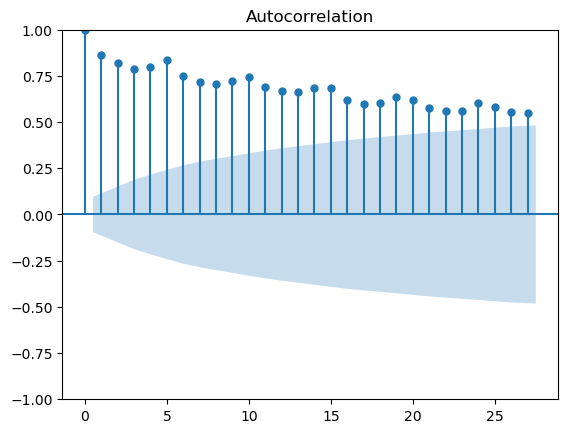

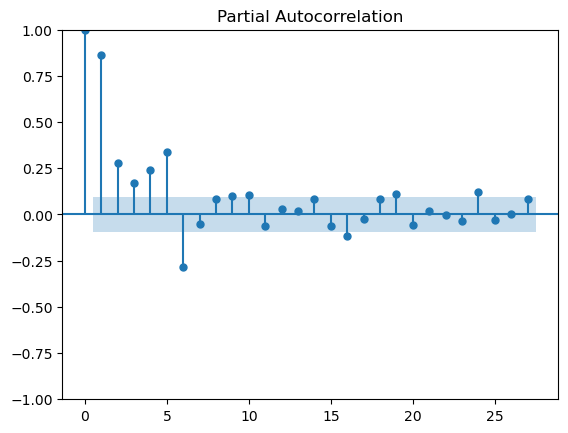

In [8]:
# Train-test split
df_train = df['impl_volatility']['2021-01-04':'2022-08-31'] # first 1 year and 8 months
df_test = df['impl_volatility']['2022-09-01':'2023-03-01'] # last 6 months

# ACF and PACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acd = plot_acf(df_train)
pacf = plot_pacf(df_train)

# ADF test (hypothesis: non-stationary time series)
from statsmodels.tsa.stattools import adfuller 
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

Both graphs and the $p$-value from the ADF test indicate highly non stationary data. We transform to stationary by finding the first differences times series. 

<Axes: xlabel='date'>

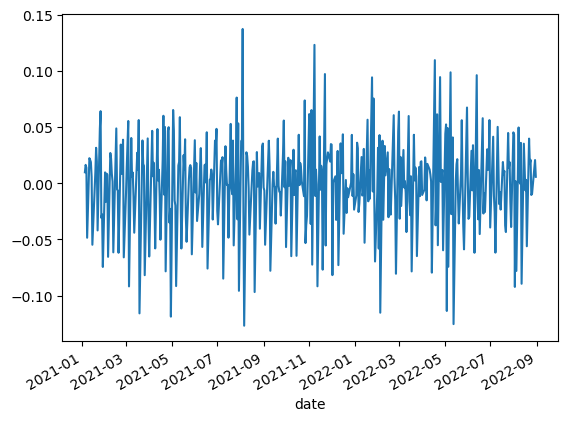

In [9]:
df_diff_train = df_train.diff().dropna()
df_diff_train.plot()

This looks much more stationary now. Let us run the tests again! 

p-value: 5.6840557302310136e-08


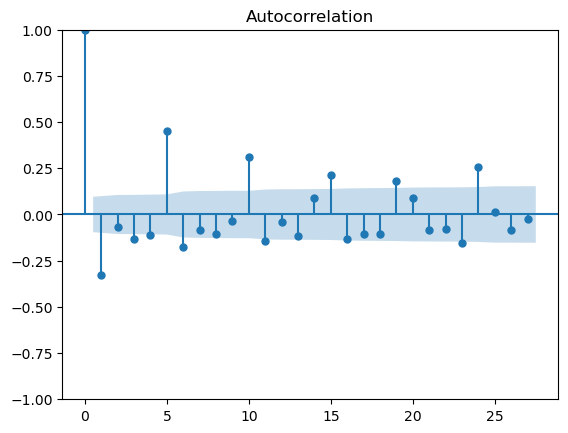

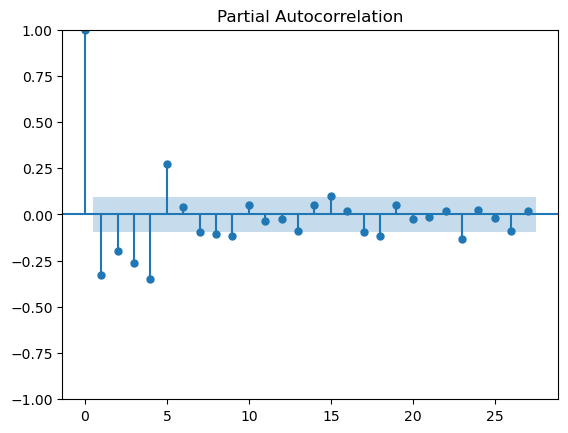

In [10]:
# ACF and PACF plot
acd = plot_acf(df_diff_train)
pacf = plot_pacf(df_diff_train)

# ADF test (hypothesis: non-stationary time series)
adf_test = adfuller(df_diff_train)
print(f'p-value: {adf_test[1]}')

Compared to the original data, the ACF plot drops in value more quickly, and similatly for the PCAF. The p-value is small enough to reject the null hypothesis. This means that the first-difference time series is likely to be stationary. This means we can take `d=1` in the ARIMA model, dealing with I.

**Fit the ARIMA model**

In [11]:
# from statsmodels.tsa.arimea.model import ARIMA
model = ARIMA(endog=df_train, order=(0, 1, 5))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:        impl_volatility   No. Observations:                  419
Model:                 ARIMA(0, 1, 5)   Log Likelihood                 803.130
Date:                Fri, 26 Apr 2024   AIC                          -1594.259
Time:                        10:03:41   BIC                          -1570.046
Sample:                             0   HQIC                         -1584.687
                                - 419                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3770      0.053     -7.158      0.000      -0.480      -0.274
ma.L2         -0.0924      0.047     -1.958      0.050      -0.185       0.000
ma.L3         -0.2189      0.046     -4.748      0.0

/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


**Making predictions**

/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='date'>

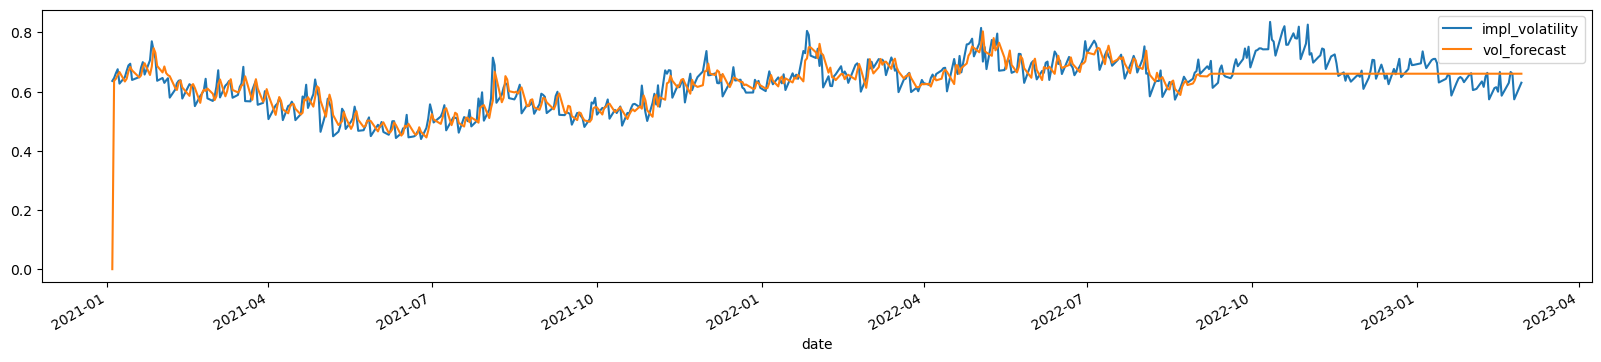

In [12]:
start_date = '2021-01-04'
end_train_date   = '2022-08-31'
start_test_date = '2022-09-01'
end_date   = '2023-02-28'
forecast_test = results.forecast(len(df_test))
df['vol_forecast'] = results.predict(start=start_date, end=end_train_date)
df['vol_forecast'][start_test_date:end_date] = list(forecast_test)
df[['impl_volatility', 'vol_forecast']].plot(figsize=(20,4)) # plot

It is now apparent that the prediction converges to constant values. Since we only need a base model to compare against, we build two ARIMA models (one with `d=1` and the other one with `d=0`) using the whole data. 

In [13]:
model1 = ARIMA(endog=df['impl_volatility'], order=(0, 1, 5))
results1 = model1.fit()
print(results1.summary())

model2 = ARIMA(endog=df['impl_volatility'], order=(0, 0, 5))
results2 = model2.fit()
print(results2.summary())

/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

                               SARIMAX Results                                
Dep. Variable:        impl_volatility   No. Observations:                  542
Model:                 ARIMA(0, 1, 5)   Log Likelihood                1044.000
Date:                Fri, 26 Apr 2024   AIC                          -2075.999
Time:                        10:03:41   BIC                          -2050.239
Sample:                             0   HQIC                         -2065.925
                                - 542                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4285      0.046     -9.235      0.000      -0.519      -0.338
ma.L2         -0.0967      0.045     -2.162      0.031      -0.184      -0.009
ma.L3         -0.1520      0.043     -3.513      0.0

/Users/vmastr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='date'>

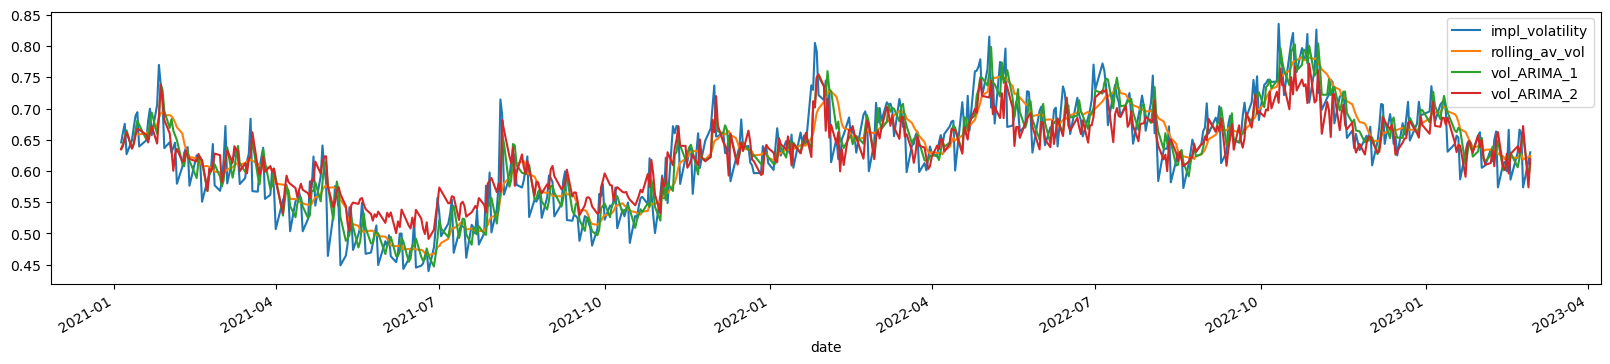

In [14]:
df['vol_ARIMA_1'] = results1.predict(start=start_date, end=end_date)
df['vol_ARIMA_2'] = results2.predict(start=start_date, end=end_date)
df['2021-01-05': end_date][['impl_volatility', 'rolling_av_vol', 'vol_ARIMA_1', 'vol_ARIMA_2']].plot(figsize=(20,4)) # plot

**Evaluating the model**

We valuate the model on three metris: 

1. **Mean Absolute Error (MAE):** The average of the absolute differences between forecasted values and the actual values. Lower values indicate better accuracy.

2. **Mean Squared Error (MSE):** The average of the squared differences between forecasted values and the actual values. Lower values indicate better accuracy. MSE penalizes larger errors more heavily compared to MAE. 

3. **Root Squared Error (RSE):** The square root of the MSE. It is in the same unit as the original data and provides an interpretable measure of forecasting accuracy. 

In [15]:
# Get the forecasted and actual values
actual_values = df['impl_volatility']
RA_values = df.loc[pd.Timestamp('2021-01-15'):]['rolling_av_vol']
actual_values_RA = df.loc[pd.Timestamp('2021-01-15'):]['impl_volatility']
ARIMA_1_values = df['vol_ARIMA_1']
ARIMA_2_values = df['vol_ARIMA_2']

# Calculate metrics
mae_RA = metrics.mean_absolute_error(actual_values_RA, RA_values)
mse_RA = metrics.mean_squared_error(actual_values_RA, RA_values)
rmse_RA = np.sqrt(mse_RA)

mae_ARIMA_1 = metrics.mean_absolute_error(actual_values, ARIMA_1_values)
mse_ARIMA_1 = metrics.mean_squared_error(actual_values, ARIMA_1_values)
rmse_ARIMA_1 = np.sqrt(mse_ARIMA_1)

mae_ARIMA_2 = metrics.mean_absolute_error(actual_values, ARIMA_2_values)
mse_ARIMA_2 = metrics.mean_squared_error(actual_values, ARIMA_2_values)
rmse_ARIMA_2 = np.sqrt(mse_ARIMA_2)


# Print the metrics
print(f"Mean Absolute Error (MAE): RA {mae_RA} , ARIMA_1 {mae_ARIMA_1}, ARIMA_2 {mae_ARIMA_2}")
print(f"Mean Squared Error (MSE): RA {mae_ARIMA_1}, ARIMA_1 {mse_ARIMA_1}, ARIMA_2 ={mse_ARIMA_2}")
print(f"Root Mean Squared Error (RMSE): RA {mae_ARIMA_2}, ARIMA_1 {rmse_ARIMA_1}, ARIMA_2 = {rmse_ARIMA_2}")

Mean Absolute Error (MAE): RA 0.028015008357842916 , ARIMA_1 0.02793990596127006, ARIMA_2 0.03233181767937429
Mean Squared Error (MSE): RA 0.02793990596127006, ARIMA_1 0.0019772494793422694, ARIMA_2 =0.001664542561999673
Root Mean Squared Error (RMSE): RA 0.03233181767937429, ARIMA_1 0.044466273504109484, ARIMA_2 = 0.04079880588938447


# Other models

## 1. Feature Selection

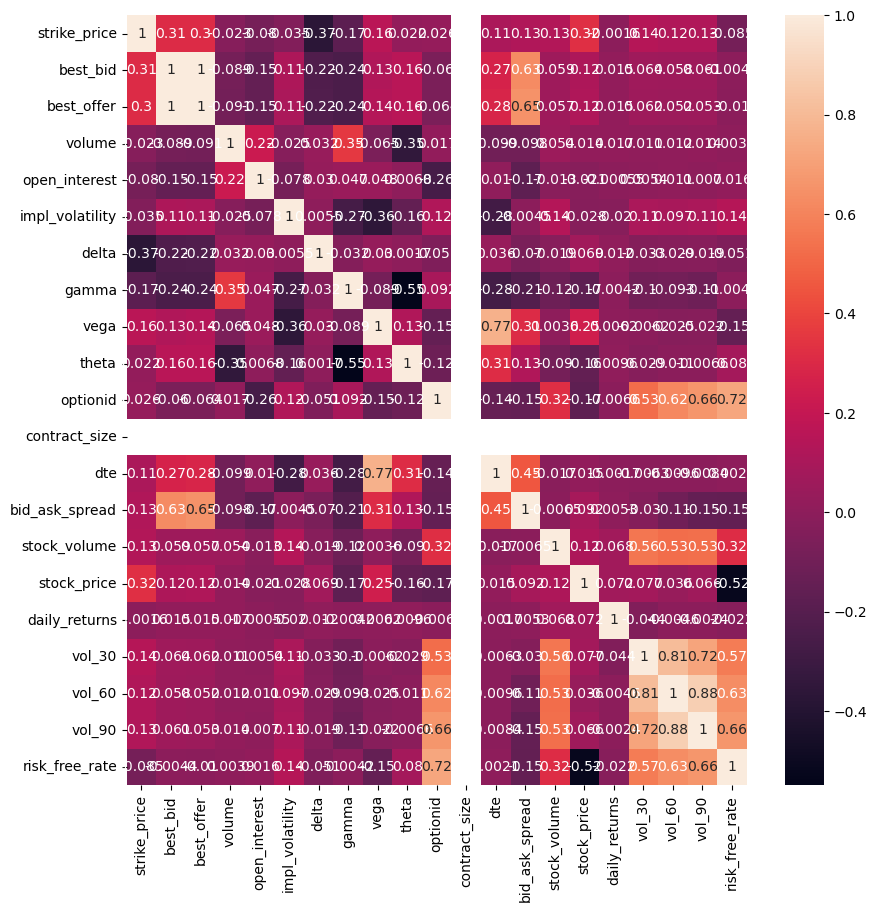

In [16]:
data2 = data.drop(['date', 'symbol', 'exdate', 'cp_flag', 'ticker'], axis=1)

# Correlation Matrix
corrM = data2.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corrM, annot=True, ax=ax)
plt.show()

We are predicting 'impl_volatility', so we want to know how other variables correlate with 'impl_volatility'.

In [17]:
# Calculating the correlation of column A against all others
corr_matrix = data2.corr()['impl_volatility']

# Sort correlation pairs 
sorted_matrix = corr_matrix.sort_values(ascending = False) 

sorted_matrix

impl_volatility    1.000000
risk_free_rate     0.142584
stock_volume       0.139528
optionid           0.124391
best_bid           0.110972
vol_30             0.110083
best_offer         0.107924
vol_90             0.107202
vol_60             0.096687
delta              0.005475
bid_ask_spread    -0.004503
daily_returns     -0.020301
volume            -0.025067
stock_price       -0.028201
strike_price      -0.035236
open_interest     -0.078450
theta             -0.155737
gamma             -0.267703
dte               -0.281714
vega              -0.360044
contract_size           NaN
Name: impl_volatility, dtype: float64

The 'contract_size' doesn't have any correlation with 'impl_volatility', so we will remove it from all feature sets. 

## 2. Linear regression

In [18]:
y = data2['impl_volatility'].values.reshape(-1,1)
X = data2.drop(['impl_volatility', 'contract_size'], axis=1)             # can only use numerical data for this model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

(588078, 19) (588078, 1)
(147020, 19) (147020, 1)


In [19]:
# Normalization of the training and test 
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  # subtract each value by the mean of the column and then divide by the stdv of the column
X_test = sc.transform(X_test) 

regressor = LinearRegression()  
regressor.fit(X_train, y_train)      # training the algorithm

print(regressor.intercept_)          # To retrieve the intercept

print(regressor.coef_)               # To retrieve the slope

[0.63163457]
[[-2.54035879e-02 -5.84914976e+08  6.00422030e+08  5.66807826e-03
  -9.86504398e-03  4.98092337e-03 -1.79925010e-01 -5.07332107e-02
  -1.31303663e-01 -2.46625811e-03 -7.12115890e-02 -2.43017326e+07
   1.22747732e-02 -1.61224775e-02 -5.21534314e-03 -5.87781504e-04
  -1.15114816e-02 -1.81030989e-02  5.59502291e-02]]


Mean Absolute Error: 0.1486165977028449
Mean Squared Error: 0.06333862282224997
Root Mean Squared Error: 0.2516716567717747
R squared: 0.3830085586164793


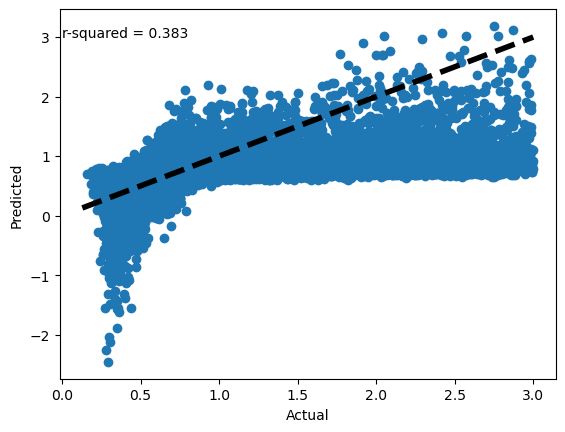

In [20]:
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared:', metrics.r2_score(y_test, y_pred))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.annotate("r-squared = {:.3f}".format(metrics.r2_score(y_test, y_pred)), (0, 3))
plt.show()

In [21]:
print('Prediction range:', np.min(y_pred), np.max(y_pred))
print('Actual range:', np.min(y_test), np.max(y_test))

Prediction range: -2.458194567653276 3.1868140407607397
Actual range: 0.157611 2.999485


It seems that Linear Regression is not the right algorithm for this type of dataset. <br>
The actual volatility of AMD options are all positie values, but the Linear Regression can predict negative values which are invalid in real life. 

## 3. Random Forest

We set the maximum depth of each decision tree to be 20 because we want to make the model simple by starting with fewer parameters. <br>
To find the opimal feature sets for random forest, we will train multiple simple random forests with n_estimator = 5 with different features sets. <br>
Then we will retrain the model with that feature sets for different n_estimator ranging from 0 to 30 to find the optimal n_estimator. <br>
The model with the optimal n_estimator and feature set will be our final random forest model. 

### 3a. Train with different feature sets

We begin by training with all features available in the dataset. This is the full model. 

(588078, 19) (588078,)
(147020, 19) (147020,)
Mean Absolute Error for Random Forests: 0.016976183568622485
Mean Squared Error for Random Forests: 0.001115333497336146
Root Mean Squared Error for Random Forests: 0.03339660906942719
R squared: 0.989135361782716


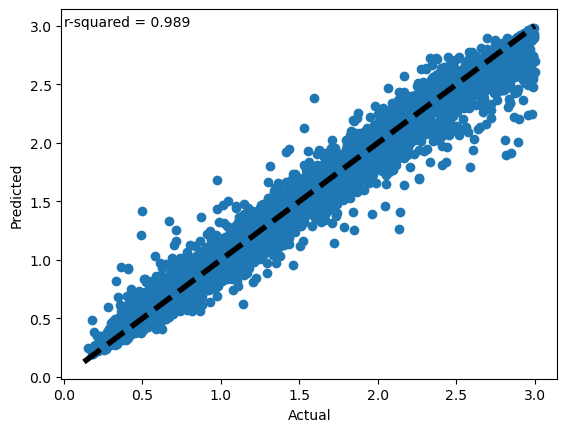

In [22]:
y = data2['impl_volatility']
X = data2.drop(['impl_volatility', 'contract_size'], axis=1)           # again, data needs to be numerical, cannot be string or timestamp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle = True)
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

# Normalization of the training and test 
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  # subtract each value by the mean of the column and then divide by the stdv of the column
X_test = sc.transform(X_test) 

regressor = RandomForestRegressor(max_depth=20, n_estimators=5, random_state=0)  # set up random forest
regressor.fit(X_train, y_train)         # train the model

# ======================================================
y_pred_rf = regressor.predict(X_test)  

print('Mean Absolute Error for Random Forests:', metrics.mean_absolute_error(y_test, y_pred_rf))  
print('Mean Squared Error for Random Forests:', metrics.mean_squared_error(y_test, y_pred_rf))  
print('Root Mean Squared Error for Random Forests:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))) 
print('R squared:', metrics.r2_score(y_test, y_pred_rf))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_rf)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.annotate("r-squared = {:.3f}".format(metrics.r2_score(y_test, y_pred_rf)), (0, 3))
plt.show()

Now let's try to reduce the numbers of features used in training by removing any variables that have correlation with 'impl_volatility' between -0.1 and 0.1. 

(588078, 11) (588078,)
(147020, 11) (147020,)


Mean Absolute Error for Random Forests: 0.02149234906012056
Mean Squared Error for Random Forests: 0.0017634510293352132
Root Mean Squared Error for Random Forests: 0.041993464126399635
R squared: 0.9828219474324191


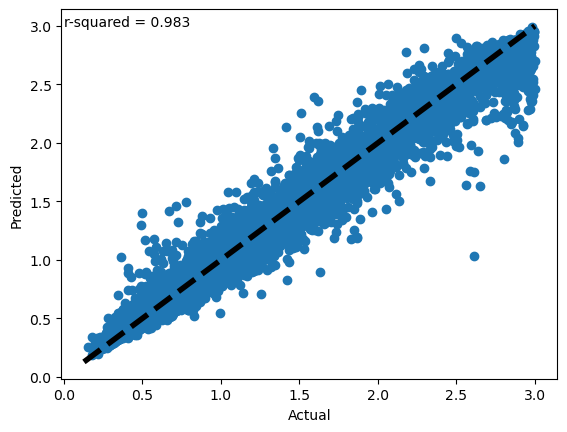

In [23]:
y = data2['impl_volatility']

# remove any variables that have correlation between -0.1 and 0.1
X = data2.drop(['impl_volatility', 'contract_size', 'vol_60', 'delta', 'bid_ask_spread', 'daily_returns', 'volume', 
               'stock_price', 'strike_price', 'open_interest'], axis=1)           

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle = True)
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

# Normalization of the training and test 
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  # subtract each value by the mean of the column and then divide by the stdv of the column
X_test = sc.transform(X_test) 

regressor = RandomForestRegressor(max_depth=20, n_estimators=5, random_state=0)  # set up random forest
regressor.fit(X_train, y_train)         # train the model

# ======================================================
y_pred_rf = regressor.predict(X_test)  

print('Mean Absolute Error for Random Forests:', metrics.mean_absolute_error(y_test, y_pred_rf))  
print('Mean Squared Error for Random Forests:', metrics.mean_squared_error(y_test, y_pred_rf))  
print('Root Mean Squared Error for Random Forests:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))) 
print('R squared:', metrics.r2_score(y_test, y_pred_rf))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_rf)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.annotate("r-squared = {:.3f}".format(metrics.r2_score(y_test, y_pred_rf)), (0, 3))
plt.show()

Seems like we removed too many variable as the performance of the model slight decreases compare to when we use the full model. <br>
Let's retrain but this time we only remove variables with correlation between -0.01 and 0.01.

(588078, 17) (588078,)
(147020, 17) (147020,)
Mean Absolute Error for Random Forests: 0.017033598219894606
Mean Squared Error for Random Forests: 0.0011344145145147035
Root Mean Squared Error for Random Forests: 0.03368107056663584
R squared: 0.9889494906070023


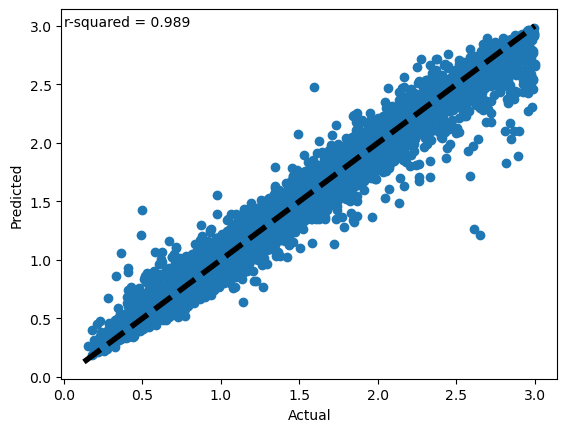

In [24]:
y = data2['impl_volatility']

# remove any variables that have correlation between -0.01 and 0.01
X = data2.drop(['impl_volatility', 'contract_size', 'delta', 'bid_ask_spread'], axis=1)           

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle = True)
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

# Normalization of the training and test 
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  # subtract each value by the mean of the column and then divide by the stdv of the column
X_test = sc.transform(X_test) 

regressor = RandomForestRegressor(max_depth=20, n_estimators=5, random_state=0)  # set up random forest
regressor.fit(X_train, y_train)         # train the model

# ======================================================
y_pred_rf = regressor.predict(X_test)  

print('Mean Absolute Error for Random Forests:', metrics.mean_absolute_error(y_test, y_pred_rf))  
print('Mean Squared Error for Random Forests:', metrics.mean_squared_error(y_test, y_pred_rf))  
print('Root Mean Squared Error for Random Forests:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))) 
print('R squared:', metrics.r2_score(y_test, y_pred_rf))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_rf)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.annotate("r-squared = {:.3f}".format(metrics.r2_score(y_test, y_pred_rf)), (0, 3))
plt.show()

Removing 'delta' and 'bid_ask_spread', which have very low correlations, doesn't affect the performance of our model much. <br>
This model with only 17 independent variables is comparable to the full model, while using fewer variables. <br>
We will use the same feature sets to find the optimal n_estimator. 

### 3b. Find optimal n_estimator

In [25]:
y = data2['impl_volatility']

# remove any variables that have correlation between -0.01 and 0.01
X = data2.drop(['impl_volatility', 'contract_size', 'delta', 'bid_ask_spread'], axis=1)           

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle = True)
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

# Normalization of the training and test 
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  # subtract each value by the mean of the column and then divide by the stdv of the column
X_test = sc.transform(X_test) 

(588078, 17) (588078,)
(147020, 17) (147020,)


In [26]:
# Finding the optimal n_estimators for random forest
R_squared =[]
MSE = []
for k in range(1, 31):
    rf = RandomForestRegressor(max_depth=20, n_estimators = k)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    R_squared.append(metrics.r2_score(y_test, y_pred))
    MSE.append(metrics.mean_squared_error(y_test, y_pred))

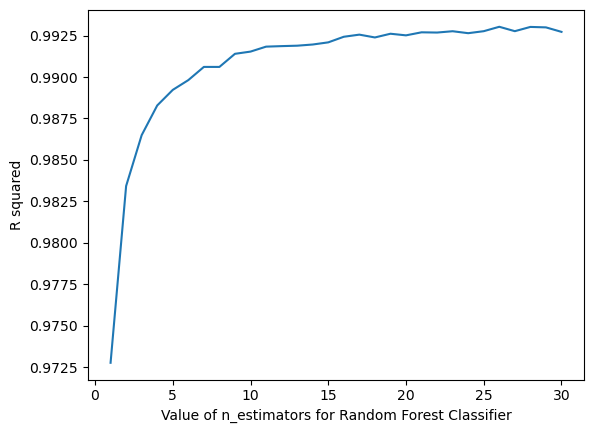

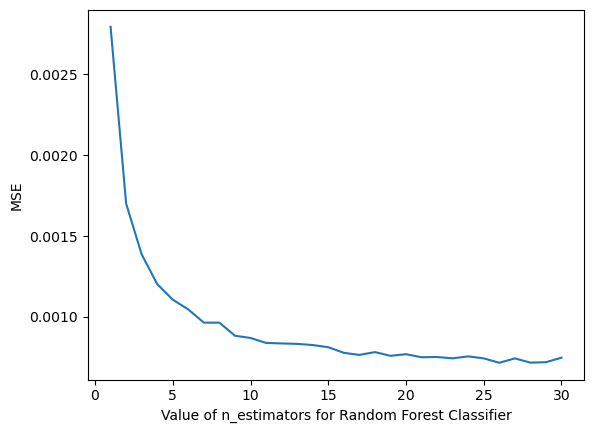

In [27]:
# plot the relationship between K and R squared
plt.figure()
plt.plot(range(1, k+1), R_squared)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('R squared')
plt.show()

# plot the relationship between K and MSE
plt.figure()
plt.plot(range(1, k+1), MSE)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('MSE')
plt.show()

The optimal n_estimator seems to be around 20, so we will retrain the random forest with this n_estimator and the same feature set. 

### 3c. Retrain with optimal n_estimator

(588078, 17) (588078,)
(147020, 17) (147020,)


Mean Absolute Error for Random Forests: 0.014078574479995136
Mean Squared Error for Random Forests: 0.0007694585249101656
Root Mean Squared Error for Random Forests: 0.027739115431285214
R squared: 0.9925045840402708


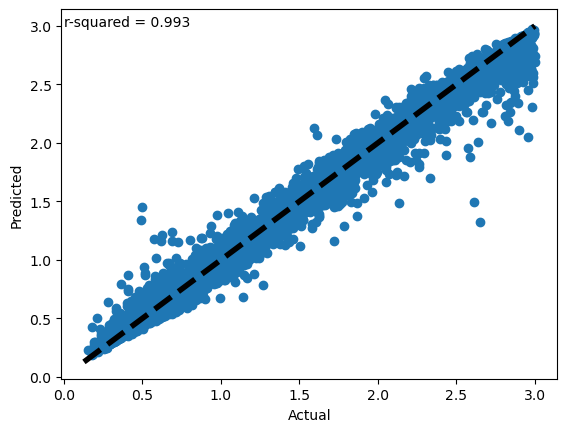

In [28]:
y = data2['impl_volatility']

# remove any variables that have correlation between -0.01 and 0.01
X = data2.drop(['impl_volatility', 'contract_size', 'delta', 'bid_ask_spread'], axis=1)           

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle = True)
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

# Normalization of the training and test 
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  # subtract each value by the mean of the column and then divide by the stdv of the column
X_test = sc.transform(X_test) 

regressor = RandomForestRegressor(max_depth=20, n_estimators=20, random_state=0)  # set up random forest
regressor.fit(X_train, y_train)         # train the model

# ======================================================
y_pred_rf = regressor.predict(X_test)  

print('Mean Absolute Error for Random Forests:', metrics.mean_absolute_error(y_test, y_pred_rf))  
print('Mean Squared Error for Random Forests:', metrics.mean_squared_error(y_test, y_pred_rf))  
print('Root Mean Squared Error for Random Forests:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))) 
print('R squared:', metrics.r2_score(y_test, y_pred_rf))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_rf)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.annotate("r-squared = {:.3f}".format(metrics.r2_score(y_test, y_pred_rf)), (0, 3))
plt.show()

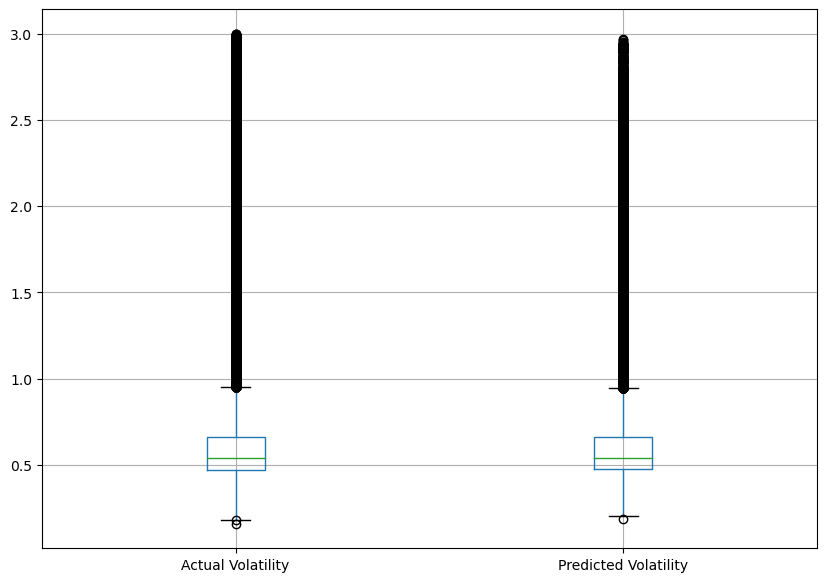

In [29]:
df_pred = pd.DataFrame()
df_pred['Actual Volatility'] = y_test
df_pred['Predicted Volatility'] = y_pred_rf

fig = plt.figure(figsize =(10, 7))
boxplot = df_pred.boxplot(column=['Actual Volatility', 'Predicted Volatility'])  
plt.show()

In [30]:
df_pred.describe()

,Actual Volatility,Predicted Volatility
count,147020.000000,147020.000000
mean,0.632206,0.631877
std,0.320403,0.314966
min,0.157611,0.186992
25%,0.470184,0.472746
50%,0.537073,0.538506
75%,0.662465,0.661698
max,2.999485,2.969903
